In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch


import models.helper as hlp
from models.unet.model import UNet
import forward.rolling.method as fwd


if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")

%load_ext autoreload
%autoreload 2

5 GPU(s) available:
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


## first lets just test the rolling code is working, and we can train a unet

In [47]:
minidir = '20230224_grating_data_mask_8__3_45'
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/'+minidir +'/'


# Load the data
orig_undisp_cube = torch.tensor(np.load(dir+'/undisp_cube.npy')).permute(0,3,1,2)
undisp_cube = orig_undisp_cube[...,300:400,:]
spectras = np.load(dir+'/true_spectra.npy')
dispersions = np.load(dir+'/dispersions.npy')



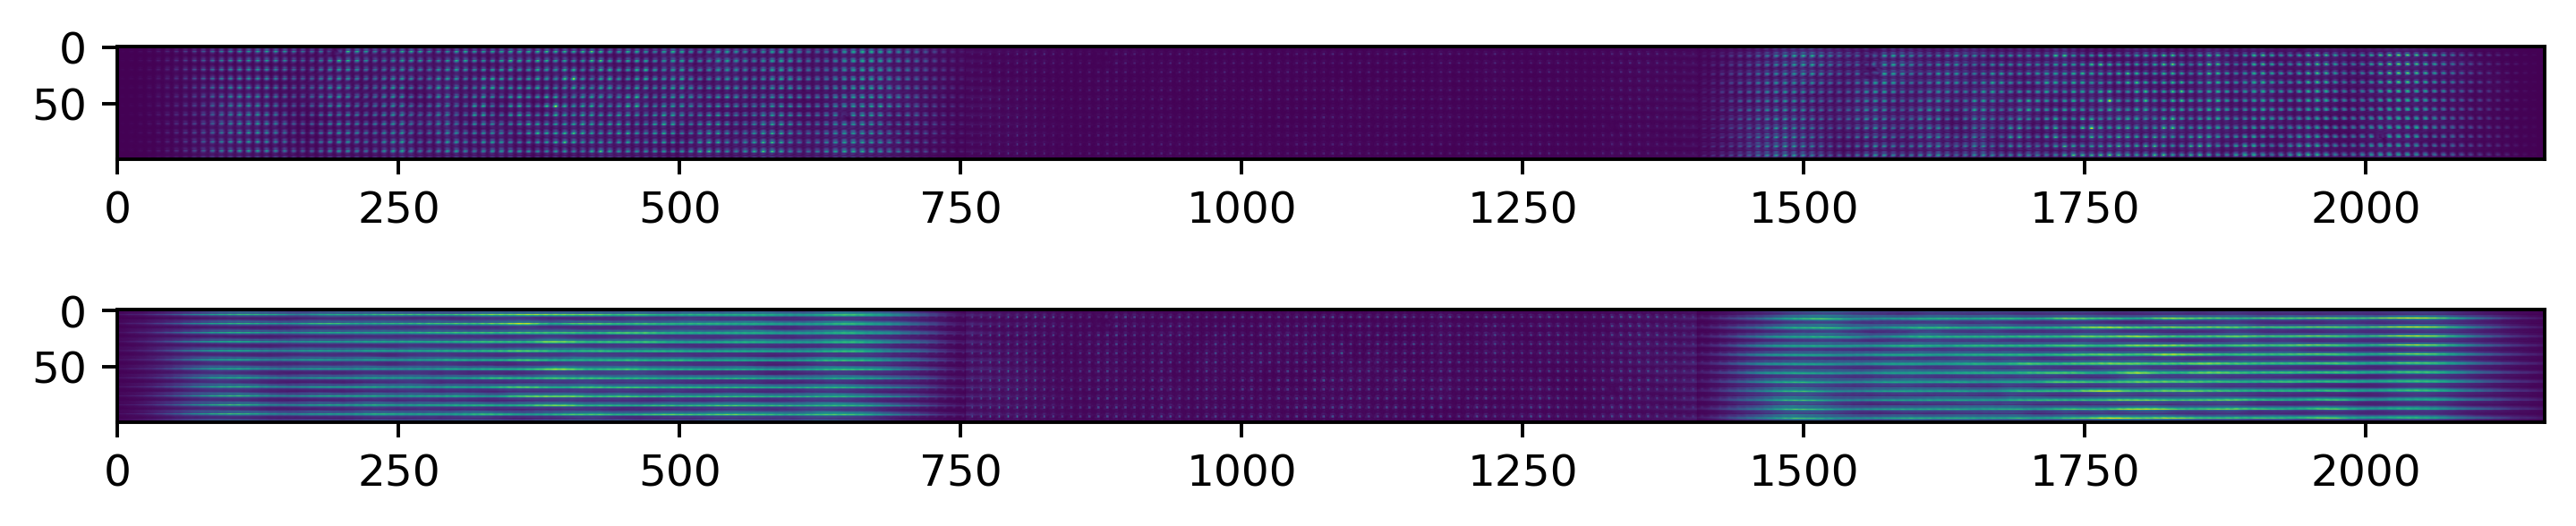

In [48]:
flattened = fwd.calc_psi_z(torch.ones_like(undisp_cube),undisp_cube,shift_info={'dispersions':dispersions})

fig,ax = plt.subplots(2,1,dpi=350,figsize=(10,2))
ax[0].imshow(torch.sum(undisp_cube,dim=1)[0])
ax[1].imshow(flattened[0])

In [55]:
batch_size = 10

dataset = hlp.SyntheticDataset(undispersed_cube=undisp_cube,dispersions = dispersions, spectra = spectras)

allindexes = np.arange(len(dataset))
np.random.shuffle(allindexes)

tr_indexes = allindexes[:int(0.05*len(allindexes))]
v_indexes = allindexes[int(0.05*len(allindexes)):int(0.06*len(allindexes))]

# Create a data loader for batch processing
tr_loader = hlp.CustomDataLoader(dataset, tr_indexes, batch_size=batch_size, shuffle=True)
v_loader = hlp.CustomDataLoader(dataset, v_indexes, batch_size=batch_size, shuffle=True)

x,y = dataset[0]

model = UNet(n_channels=1, n_classes=75, bilinear=True)
model = model.to('cuda')

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss = torch.nn.MSELoss()


history = hlp.train(model, optimizer, loss, tr_loader, v_loader, epochs=3, device='cuda')

/home/s/Sunny.Howard/SCI/models/helper.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(undispersed_cube)


train() called: model=UNet, opt=SGD(lr=0.001000), epochs=3, device=cuda

epoch 1
Epoch   1/  3, train loss: 0.0074708, val loss: 0.0076662
epoch 2
epoch 314/ 14, loss: 0.0074033
Batch  14/ 14, loss: 0.0073205
Time total:     168.41 sec
Time per epoch: 56.14 sec


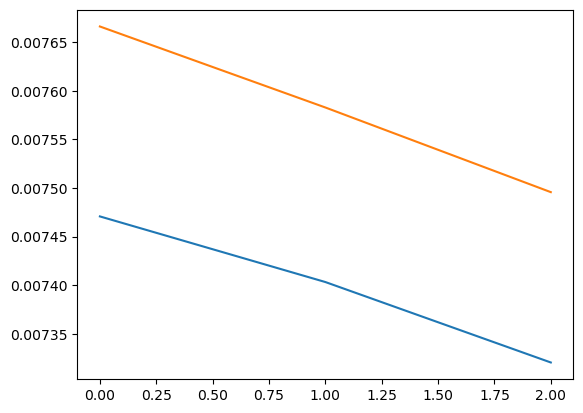

In [56]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

### Can we test the fourier kernel?

In [43]:
from forward.fourier import method, kernel_creator

In [44]:
kernel = kernel_creator.create_fourier_kernel();

#taken from jannik
signalfft_center = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230508_mask_analysis_talbot_0_300us/signalfft_padded_center.npy')
signalfft_left = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230508_mask_analysis_talbot_0_300us/signalfft_padded_left.npy')
signalfft_right = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230508_mask_analysis_talbot_0_300us/signalfft_padded_right.npy')

signal_fft = np.concatenate((signalfft_left,signalfft_center,signalfft_right),axis = 1)

wavls = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/gratings_wavelengths.npy')
wavelengths = np.arange(750,851,5)
idx = np.zeros_like(wavelengths)
for i in np.arange(len(wavelengths)):
    idx[i] = (np.abs(wavls - wavelengths[i]*1e-9)).argmin()

wavls_21 = wavls[idx]
signal_fft_21 = signal_fft[:,:,idx]


/tmp/user/25186/ipykernel_1556021/4165685932.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel9 = torch.tensor(kernel).unsqueeze(0).permute(0,3,1,2)


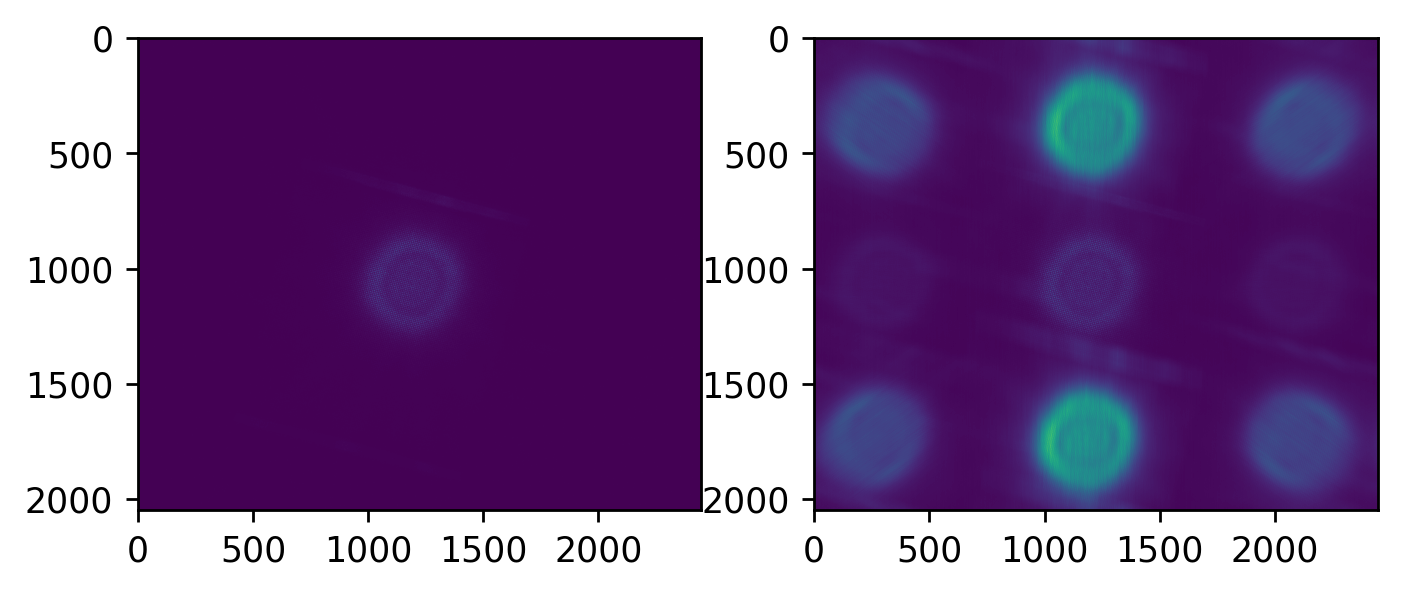

In [46]:
cube = torch.tensor(signal_fft_21).unsqueeze(0).permute(0,3,1,2)
kernel9 = torch.tensor(kernel).unsqueeze(0).permute(0,3,1,2)

dispersed_cube = torch.abs(method.calc_psi_z(torch.ones_like(cube),cube,kernel9)[0])

fig,ax = plt.subplots(1,2,dpi=250)
ax[0].imshow(cube[0,10,:])
ax[1].imshow(dispersed_cube)